# ENVIRONMENT

In [1]:
from __future__ import division
import itertools
# import warnings
# warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()

# DATA ACQUISITION

In [3]:
colnames=['d1', 'd2', 'page_viewed', 'user_id', 'cohort', 'ip']
df_orig = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=' ',
                 na_values='"-"')

df = df_orig.copy()
df.head()

,d1,d2,page_viewed,user_id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
df['date'] = df.d1 + ' ' + df.d2

In [5]:
df = df.drop(columns=['d1', 'd2'])

In [6]:
df.head(10)

,page_viewed,user_id,cohort,ip,date
0,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24
5,javascript-i/loops,2,22.0,97.105.19.61,2018-01-26 09:56:41
6,javascript-i/conditionals,3,22.0,97.105.19.61,2018-01-26 09:56:46
7,javascript-i/functions,3,22.0,97.105.19.61,2018-01-26 09:56:48
8,javascript-i/loops,2,22.0,97.105.19.61,2018-01-26 09:56:59
9,javascript-i/functions,4,22.0,97.105.19.61,2018-01-26 09:58:26


### Parse Datetime

In [7]:
df = df.set_index('date')

In [8]:
df.head(10)

,page_viewed,user_id,cohort,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61


In [9]:
df.describe()
df.head(10)

,page_viewed,user_id,cohort,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233528 entries, 2018-01-26 09:55:03 to 2019-04-02 11:11:29
Data columns (total 4 columns):
page_viewed    233528 non-null object
user_id        233528 non-null int64
cohort         219070 non-null float64
ip             233528 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 8.9+ MB


In [11]:
df = df.reset_index()
df.head()

,date,page_viewed,user_id,cohort,ip
0,2018-01-26 09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233528 entries, 0 to 233527
Data columns (total 5 columns):
date           233528 non-null datetime64[ns]
page_viewed    233528 non-null object
user_id        233528 non-null int64
cohort         219070 non-null float64
ip             233528 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 8.9+ MB


In [14]:
df.cohort.value_counts()

24.0    34485
22.0    28268
23.0    26655
25.0    24681
26.0    24088
29.0    20471
27.0    19255
1.0      8821
14.0     6523
21.0     6465
28.0     6163
31.0     2997
13.0     2163
17.0     1805
8.0      1671
18.0     1482
19.0      901
16.0      740
15.0      632
7.0       338
12.0      230
2.0        89
11.0       79
6.0        59
9.0         5
4.0         4
Name: cohort, dtype: int64

In [15]:
df = df.loc[df['cohort'] == 22].drop(columns='cohort')

In [16]:
df = df.set_index('date')

In [17]:
df.head()

,page_viewed,user_id,ip
date,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61
2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61
2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61
2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61


In [18]:
df = pd.concat([df, pd.DataFrame(df.index.hour, index=df.index)], axis = 1)

In [19]:
df.index.name = 'timestamp'

In [20]:
df.head()

,page_viewed,user_id,ip,date
timestamp,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,9
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,9
2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61,9
2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61,9
2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61,9


In [21]:
df = df.rename(index=str, columns={"date": "hour"})
df.head()

,page_viewed,user_id,ip,hour
timestamp,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,9
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,9
2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61,9
2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61,9
2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61,9


In [22]:
df.loc[(df['hour'] < 5) | (df['hour'] > 20)]

,page_viewed,user_id,ip,hour
timestamp,,,,
2018-01-26 21:10:38,/,19,96.8.150.23,21
2018-01-26 21:10:42,javascript-i,19,96.8.150.23,21
2018-01-26 21:10:44,javascript-i/functions,19,96.8.150.23,21
2018-01-26 21:10:45,javascript-i/conditionals,19,96.8.150.23,21
2018-01-26 21:10:46,javascript-i/functions,19,96.8.150.23,21
2018-01-26 21:11:12,/,19,96.8.150.23,21
2018-01-26 21:11:15,javascript-i,19,96.8.150.23,21
2018-01-26 21:11:18,javascript-i/functions,19,96.8.150.23,21
2018-01-26 21:11:25,javascript-i/conditionals,19,96.8.150.23,21


In [23]:
df.head()

,page_viewed,user_id,ip,hour
timestamp,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,9
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,9
2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61,9
2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61,9
2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61,9


In [24]:
df = df.reset_index()
df.head()

,timestamp,page_viewed,user_id,ip,hour
0,2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,9
1,2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,9
2,2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61,9
3,2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61,9
4,2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61,9


In [25]:
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df.head()

,page_viewed,user_id,ip,hour
timestamp,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,9
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,9
2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61,9
2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61,9
2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61,9


In [26]:
df.shape

(28268, 4)

In [27]:
df.head()

,page_viewed,user_id,ip,hour
timestamp,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,9
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,9
2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61,9
2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61,9
2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61,9


In [45]:
dft = df['page_viewed'].resample('D').count()
dft.head()

timestamp
2018-01-26    323
2018-01-27     53
2018-01-28    108
2018-01-29    433
2018-01-30    349
Freq: D, Name: page_viewed, dtype: int64

In [50]:
idx = pd.date_range(
    dft.sort_index().index.min(), 
    dft.sort_index().index.max(),
    freq="D"
)

dft = dft.reindex(idx, fill_value=0).fillna(value=0)

In [51]:
dft.head()

2018-01-26    323
2018-01-27     53
2018-01-28    108
2018-01-29    433
2018-01-30    349
Freq: D, Name: page_viewed, dtype: int64

In [52]:
short_rolling

timestamp
2018-01-26           NaN
2018-01-27           NaN
2018-01-28           NaN
2018-01-29           NaN
2018-01-30           NaN
2018-01-31           NaN
2018-02-01           NaN
2018-02-02           NaN
2018-02-03           NaN
2018-02-04           NaN
2018-02-05           NaN
2018-02-06    303.750000
2018-02-07    292.666667
2018-02-08    310.083333
2018-02-09    323.833333
2018-02-10    291.583333
2018-02-11    269.250000
2018-02-12    279.250000
2018-02-13    270.083333
2018-02-14    269.750000
2018-02-15    273.166667
2018-02-16    280.666667
2018-02-17    247.750000
2018-02-18    218.000000
2018-02-19    212.166667
2018-02-20    239.416667
2018-02-21    244.166667
2018-02-22    283.666667
2018-02-23    310.166667
2018-02-24    277.166667
                 ...    
2019-03-03      7.583333
2019-03-04      7.583333
2019-03-05      7.500000
2019-03-06      7.500000
2019-03-07      8.000000
2019-03-08      8.000000
2019-03-09      8.000000
2019-03-10      7.583333
2019-03-11     

In [53]:
# Calculating the short-window simple moving average
short_rolling = dft.rolling(window=7).mean()

# Calculating the long-window simple moving average
long_rolling = dft.rolling(window=14).mean()

Text(0, 0.5, 'Page View Count')

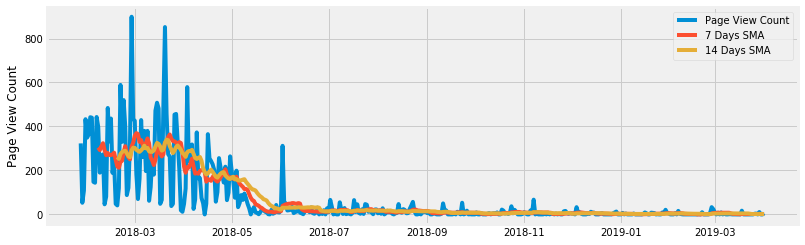

In [58]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(dft.index, 
        dft,
        label='Page View Count')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '7 Days SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '14 Days SMA')

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

In [59]:
# Using Pandas to calculate a 7 Day span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = dft.ewm(span=7, adjust=False).mean()
ema_short[0:3]

ema_long = dft.ewm(span=14, adjust=False).mean()
ema_long[0:3]

2018-01-26    323.000000
2018-01-27    287.000000
2018-01-28    263.133333
Freq: D, Name: page_viewed, dtype: float64

In [60]:
ema_long = dft.ewm(span=14, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

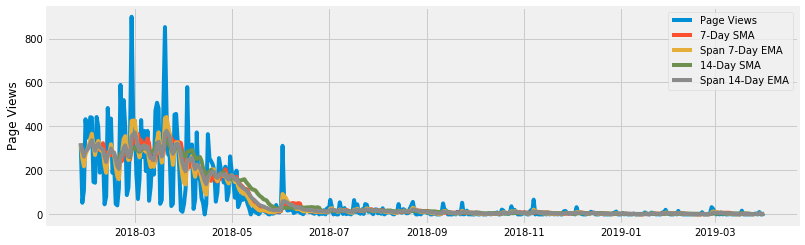

In [62]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(dft.index, 
        dft,
        label='Page Views')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '7-Day SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 7-Day EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '14-Day SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 14-Day EMA')

ax.legend(loc='best')
ax.set_ylabel('Page Views')

yhat = pd.DataFrame(dict(actual=dft))

In [72]:
ema_long = dft.ewm(span=14 , adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-14:-1].std()*3
lb = midband - ema_long[-14:-1].std()*3

yhat['moving_avg_forecast'] = midband

In [68]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [71]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2018-01-26,323,2.535946,320.464054,62.026676
2018-01-27,53,2.535946,50.464054,10.188717
2018-01-28,108,2.535946,105.464054,20.748301
2018-01-29,433,2.535946,430.464054,83.145845
2018-01-30,349,2.535946,346.464054,67.018480
2018-01-31,364,2.535946,361.464054,69.898366
2018-02-01,442,2.535946,439.464054,84.873777
2018-02-02,440,2.535946,437.464054,84.489792
2018-02-03,148,2.535946,145.464054,28.427999
2018-02-04,144,2.535946,141.464054,27.660029
